In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import numpy as np

## read the data to pandas
data = pd.read_csv('data.csv') # data organized in 'data.csv' after instr from DATA_ACCESS

## scale the data for the LSTM to understand better
scaler = MinMaxScaler()
df_mm = scaler.fit_transform(data[['icnfdr', 'u10', 'v10', 'skt', 'stl1']]) # now we have numpy array

df_mm = df_mm[:699]

train = df_mm[:524]
test = df_mm[524:]
print(len(train), len(test))

y = train[:, 0]
X = train[:, 1:]


# Handle the shared dimensionality for X,y
X = X[:699]
y = y[:699] # X,y have length 699

# turn the data from linear to frames/windows of data
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        sequences.append(seq)
    return np.array(sequences)

window_size = 7

X_seq = create_sequences(X, window_size)  # (num_samples, window_size, input_dim)
y_seq = y[window_size:]  # match the number of sequences, first window not eval'd

### Dimensionality verification
print(f"X_seq shape: {X_seq.shape}")
print(f"y_seq shape: {y_seq.shape}")


# sequences to tensors
X_seq = torch.tensor(X_seq, dtype=torch.float32)  
y_seq = torch.tensor(y_seq, dtype=torch.float32)  

# LSTM Model Defn
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)  # output and hidden states
        out = self.fc(out[:, -1, :])  # recurrency (long-range deps)
        return out

# Hyperparameters
hidden_dim = 128
output_dim = 1  # output dimension (for regression)
num_layers = 1  # LSTM layers
lr = 0.001


loss_fn = nn.MSELoss()
model = LSTMModel(input_dim=X_seq.shape[2], hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

optimizer = optim.Adam(model.parameters(), lr=lr)

# Train
epochs = 200
for epoch in range(epochs):
    model.train()  
    optimizer.zero_grad()  
    
    # Forward
    y_pred = model(X_seq) 
    loss = loss_fn(y_pred.squeeze(), y_seq)  #  loss
    
    # Backprop
    loss.backward()  
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
    optimizer.step()  
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


# preparing test data for evaluation

y_test = test[:, 0]
X_test = test[:, 1:]


X_test_seq = create_sequences(X_test, window_size)  # (num_samples, window_size, input_dim)
y_test_seq = y_test[window_size:]  # match the number of sequences, first window not eval'd

X_test = torch.tensor(X_test_seq, dtype=torch.float32)  
y_test = torch.tensor(y_test_seq, dtype=torch.float32) 

#  predictions, model is trained
model.eval() 
with torch.no_grad(): 
    predictions = model(X_test)  
    predictions = predictions.squeeze()

import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


y_test_np = y_test.numpy()
predictions_np = predictions.numpy()


mse = mean_squared_error(y_test_np, predictions_np)
print(f"Mean Squared Error: {mse:.4f}")
mae = mean_absolute_error(y_test_np, predictions_np)
print(f"Mean Absolute Error: {mae:.4f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse:.4f}")
r2 = r2_score(y_test_np, predictions_np)
print(f"R² Score: {r2:.4f}")

524 175
X_seq shape: (517, 7, 4)
y_seq shape: (517,)
Epoch [10/200], Loss: 0.0681
Epoch [20/200], Loss: 0.0580
Epoch [30/200], Loss: 0.0511
Epoch [40/200], Loss: 0.0402
Epoch [50/200], Loss: 0.0340
Epoch [60/200], Loss: 0.0340
Epoch [70/200], Loss: 0.0332
Epoch [80/200], Loss: 0.0327
Epoch [90/200], Loss: 0.0323
Epoch [100/200], Loss: 0.0319
Epoch [110/200], Loss: 0.0316
Epoch [120/200], Loss: 0.0312
Epoch [130/200], Loss: 0.0309
Epoch [140/200], Loss: 0.0305
Epoch [150/200], Loss: 0.0302
Epoch [160/200], Loss: 0.0299
Epoch [170/200], Loss: 0.0295
Epoch [180/200], Loss: 0.0292
Epoch [190/200], Loss: 0.0288
Epoch [200/200], Loss: 0.0284
Mean Squared Error: 0.0447
Mean Absolute Error: 0.1805
Root Mean Squared Error: 0.2115
R² Score: 0.4250


# Visualization for Figure 2 (Model Learning)

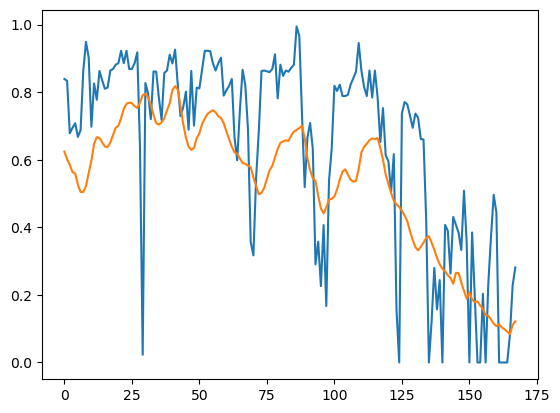

In [2]:
import matplotlib.pyplot as plt


plt.plot(y_test)
plt.plot(predictions)
plt.show()